In [ ]:
# 1.模型构造
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

# nn.Sequential定义了一种特殊的Module
# Module是所有层和神经网络的父类

tensor([[ 0.1630,  0.1536,  0.1381,  0.0982, -0.0385, -0.1175,  0.2744,  0.4624,
         -0.2161, -0.0258],
        [ 0.1083,  0.0801,  0.1259,  0.2404, -0.0359, -0.0806,  0.1981,  0.4020,
         -0.2114,  0.0699]], grad_fn=<AddmmBackward0>)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.out = nn.Linear(256, 10)

    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))

nn.Module 是 PyTorch 中构建神经网络的基础类。
通过继承 nn.Module，可以定义模型的结构、前向传播逻辑，并自动管理参数。
它是 PyTorch 模型开发的核心，支持模块化设计、设备管理、模型保存与加载等功能。

当执行 net(X) 时，PyTorch 会自动调用 nn.Module 的 __call__ 方法，而 __call__ 方法内部会调用你定义的 forward 方法。具体过程如下：

net(X) 等价于 net.__call__(X)：
nn.Module 类实现了 __call__ 方法，当实例化对象被调用时（如 net(X)），Python 会执行 __call__。
__call__ 方法的作用：
__call__ 方法在调用 forward 方法之前，会执行一些额外的逻辑（如钩子函数、前向传播的预处理等）。
最终，__call__ 会调用 forward 方法，并将结果返回。
forward 方法的执行：
forward 方法是你定义的模型前向传播逻辑，它会根据输入 X 计算输出。
因此，net(X) 实际上是通过 __call__ 间接调用了 forward(X)，并输出了结果。
当你调用 net(X) 时，X 会被传递给 forward 方法。
在 forward 方法中，X 通过隐藏层 self.hidden 和输出层 self.out 计算得到输出。

In [ ]:
class MySequential(nn.Module):
    #调用父类 nn.Module 的构造函数。确保 MySequential 类正确初始化，继承 nn.Module 的核心功能
    def __init__(self, *args): # args: 用户传入的子模块列表
        # MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10)) 中的三个模块会被打包为 args 元组。
        super().__init__()
        # 遍历传入的所有子模块（如 nn.Linear, nn.ReLU 等）
        for block in args:
            # 将每个子模块对象 block 作为键和值，添加到 self._modules 字典中
            # self._modules 是 nn.Module 内置的字典，用于跟踪子模块
            self._modules[block] = block

    def forward(self, X):
        for block in self._modules.values():
            # block(X): 正向传播的基本操作, 输入：当前的输入张量 X;
            # ​操作：将 X 传递给当前子模块 block，执行该模块的 forward 方法;
            # ​输出：当前子模块处理后的结果会覆盖 X，作为下一个子模块的输入
            X = block(X)
        return X

net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

In [ ]:
# 在教我们通过继承nn.Module, 我们如何实现比单纯的Sequential更多的功能
# 像这个函数就是在正向传播函数中执行了自定义的代码
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        X = self.linear(X)
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

net = FixedHiddenMLP()
net(X)

In [ ]:
# 层,  nn.linear, Sequential都是nn.Module的子类, 我们可以嵌套着使用(下文是Sequential和linear的嵌套)
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)

    def forward(self, X):
        return self.linear(self.net(X))

chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

chimera (Sequential)
├── NestMLP (自定义模块)
│   ├── net (Sequential)
│   │   ├── Linear(20, 64)
│   │   ├── ReLU()
│   │   ├── Linear(64, 32)
│   │   └── ReLU()
│   └── linear (Linear(32, 16))
├── Linear(16, 20)
└── FixedHiddenMLP (自定义模块)
    ├── rand_weight (固定张量 20x20)
    ├── linear (Linear(20, 20))
    └── 包含固定权重操作和归一化逻辑

In [ ]:
# 2.参数管理
# 关注一个多层感知机
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

In [ ]:
# 在PyTorch中，state_dict()是一个关键方法，用于获取神经网络模型中可学习参数的字典对象
print(net[2].state_dict()) # 因为这个模型是linear, relu, linear, 所以net[2]就是取最后一层的参数

In [ ]:
print(type(net[2].bias))# ​作用：查看 bias 参数的类型。
print(net[2].bias)# 打印 bias 参数的完整信息，包括值和梯度属性。
print(net[2].bias.data)# 直接访问 bias 参数的数值张量​（不包含梯度信息）。

In [ ]:
net[2].weight.grad == None

In [ ]:
# 一次性访问所有参数
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

In [ ]:
net.state_dict()['2.bias'].data

In [ ]:
# 我们定义了一个由嵌套快组成的网络rgnet, 里面是一个block2和一个linear层,
# 而block2里面又循环嵌套了4个block1分别命名为"block0"-"block3"
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 4),
                         nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

In [ ]:
# 内置初始化
def init_normal(m): # 正态分布初始化函数 init_normal
    if type(m) == nn.Linear:# 仅对线性层的权重和偏置进行初始化
        #作用：将权重 weight 初始化为均值为 0、标准差为 0.01 的正态分布
        # ​下划线 _ 的含义：PyTorch 中以下划线结尾的函数表示原地修改（in-place）​，即直接修改张量值而不返回新对象
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)

net.apply(init_normal)# PyTorch 中 nn.Module.apply(fn) 会递归地对所有子模块​（包括嵌套模块）应用函数 fn
net[0].weight.data[0], net[0].bias.data[0]

def init_constant(m):# ​常量初始化函数 init_constant
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)

net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

关于Parameter
​继承自 Tensor: Parameter 是 torch.Tensor 的子类，因此具备所有张量的操作功能（如数学运算、GPU 加速等）。
​专为模型参数设计它是: PyTorch 中用于标识模型可学习参数的标记类，能够被优化器自动识别并更新。
当将一个 Parameter 赋值给一个 nn.Module 的属性时，它会自动被注册到该模块的参数列表中，从而可以通过 module.parameters() 访问
用途: 模型的可学习参数（权重、偏置）

In [ ]:
# 对不同的块应用不同的初始化方法
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

In [ ]:
# 自定义初始化
def my_init(m):
    if type(m) == nn.Linear:
        print(
            "Init",
            *[(name, param.shape) for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10) # nn.init.uniform_(m.weight, -10, 10)：将权重初始化为 [-10, 10] 的均匀分布
        m.weight.data *= m.weight.data.abs() >= 5
        #m.weight.data.abs() >= 5 生成布尔掩码（True 表示绝对值 ≥5，False 表示 <5）；
        #布尔掩码转换为 0/1 值后，与原权重相乘，也就是实现了将绝对值 <5 的权重置零的操作

net.apply(my_init)
net[0].weight[:2]

In [ ]:
# 一些权重操作
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

In [ ]:
# 共享参数
shared = nn.Linear(8, 8) #先把需要共享参数的层构造出来
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), shared, nn.ReLU(), shared, #在定义层级时, 直接在需要共享的地方引入share就行
                    nn.ReLU(), nn.Linear(8, 1))
net(X)
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
print(net[2].weight.data[0] == net[4].weight.data[0])

In [ ]:
# 自定义层
import torch
import torch.nn.functional as F
from torch import nn

# 自定义一个没有任何参数的层
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()
        #  self.shift = nn.Parameter(torch.tensor(init_shift))  可学习参数,此函数中没有定义

#forward 方法接收输入张量 X，计算其均值 X.mean()，并将每个元素减去该均值，使得输出数据的均值为零
    def forward(self, X):
        return X - X.mean()

layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

In [ ]:
# 自己定义的层也可以嵌套进其他层级结构中
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

Y = net(torch.rand(4, 8))
Y.mean()

In [ ]:
# 带参数的层
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))

# forward功能: 线性变换 并 应用 ReLU 激活函数，将负值置零，保留正值，引入非线性
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

linear = MyLinear(5, 3)
linear.weight

In [ ]:
# 使用
linear(torch.rand(2, 5))
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

In [1]:
# 保存文件
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
torch.save(x, 'x-file')

x2 = torch.load('x-file')
x2

C:\user\default\AppData\Local\Temp\ipykernel_8176\845183693.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x2 = torch.load('x-file')


tensor([0, 1, 2, 3])

In [2]:
# 存储一个张量列表，然后把它们读回内存
y = torch.zeros(4)
torch.save([x, y], 'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)
# 写入或读取从字符串映射到张量的字典
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

C:\user\default\AppData\Local\Temp\ipykernel_8176\1375692550.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x2, y2 = torch.load('x-files')
C:\user\default\AppData\Local

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

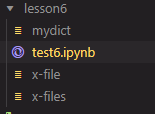可以看到我们存到并读到了这些数据

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

#pytorch中保存模型: 保存所有的参数
#state_dict()可以获取神经网络模型中可学习参数的字典对象, 我们保存state_dict()就行
torch.save(net.state_dict(), 'mlp.params')

# 保存好了, 怎么load回来呢?
# load回来的前提: 我们需要拿到模型的定义
clone = MLP()
# 载回保存的参数
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()